
# 🌬️ WindDatas – Analyse technique des données de vent

Ce notebook constitue la **base technique robuste** pour l'analyse complète des données de vent dans le cadre du projet **WindDatas**.

Il a été conçu pour :
- être **modulaire et générique**, adapté à tous les sites présents dans `../data/`
- produire une **analyse rigoureuse, reproductible et documentée**
- servir de fondation pour des enrichissements futurs (page de garde, exports Word, ajout de modèles, etc.)

---

### 🔧 Structure du notebook :
1. Imports techniques et configuration
2. Sélection dynamique du site
3. Chargement automatisé des données
4. Vérification des colonnes critiques
5. Préparation et fusion des données
6. Analyses statistiques et visuelles détaillées
7. Détection des extrêmes
8. Ajustement de lois (Weibull / Gumbel)
9. Comparaison inter-sources


In [3]:

# ============================================================
# 📦 Imports globaux – tous en tête pour éviter les erreurs
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import radians
from scipy.stats import weibull_min, gumbel_r
import warnings

# 📉 Configuration visuelle
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (10, 4)
sns.set_style("whitegrid")

# 🔇 Suppression des warnings
warnings.filterwarnings("ignore")


In [ ]:

# ============================================================
# 📂 Sélection d'un site dans le dossier ../data
# ============================================================

base_data_path = os.path.abspath(os.path.join("..", "data"))
available_sites = sorted([d for d in os.listdir(base_data_path) if os.path.isdir(os.path.join(base_data_path, d))])

if not available_sites:
    raise Exception("Aucun dossier de site trouvé dans ../data")

print("Sites disponibles :")
for i, site in enumerate(available_sites):
    print(f"{i+1}. {site}")

# 🔧 Saisie manuelle par index (robuste, pas de hardcode)
index = int(input("Entrez le numéro du site à analyser : ")) - 1
site_name = available_sites[index]
data_path = os.path.join(base_data_path, site_name)

print(f"[✅] Site sélectionné : {site_name}")
print(f"[📁] Chemin des données : {data_path}")


Sites disponibles :
1. 0ld
2. WFR001_PIOLENC
3. WFR006_CARBONNE
4. WFR049_SALLES_SUR_GARONNE
5. WFR066_GROILLONS
6. WFR070_MADONE
7. WFR090_MONPEZAT
8. WIN160_RUMSL
9. WJP104_YAMAKURA
10. WPT008_ALTO_RABAGAO
11. WTW059_CHANGBIN
12. WUK003_QE2


In [ ]:

# ============================================================
# 📥 Chargement automatisé des fichiers CSV
# ============================================================

dataframes = {}
for file in os.listdir(data_path):
    if file.endswith(".csv"):
        key = file.replace(".csv", "")
        try:
            df = pd.read_csv(os.path.join(data_path, file))
            if "time" in df.columns:
                df["time"] = pd.to_datetime(df["time"])
            elif "date" in df.columns:
                df = df.rename(columns={"date": "time"})
                df["time"] = pd.to_datetime(df["time"])
            if "time" in df.columns:
                df = df.sort_values("time")
            dataframes[key] = df
            print(f"[✅] {key} chargé ({len(df)} lignes)")
        except Exception as e:
            print(f"[❌] Erreur lecture {file} : {e}")


In [4]:

# ============================================================
# 📍 Résumé du site et période couverte
# ============================================================

site_info = {
    "Nom du site": site_name,
    "Fichiers disponibles": list(dataframes.keys())
}

all_dates = []
for df in dataframes.values():
    if "time" in df.columns:
        all_dates.extend(df["time"].dropna().tolist())

if all_dates:
    start = min(all_dates).date()
    end = max(all_dates).date()
    site_info["Période d’étude"] = f"{start} → {end}"
else:
    site_info["Période d’étude"] = "Inconnue"

print("📌 Informations sur le site :\n")
for key, value in site_info.items():
    print(f"- {key} : {value}")


📌 Informations sur le site :

- Nom du site : WFR001_PIOLENC
- Fichiers disponibles : ['era5_daily_PIOLENC', 'era5_PIOLENC', 'meteostat1_PIOLENC', 'meteostat2_PIOLENC', 'nasa_power_PIOLENC', 'openmeteo_PIOLENC', 'power_PIOLENC', 'statistics_comparison_PIOLENC']
- Période d’étude : 1975-01-01 → 2025-01-01



## 📊 Analyse statistique des vitesses moyennes et rafales

Ce bloc calcule des statistiques de base pour chaque source de données disponible :  
- nombre de valeurs (`count`)
- moyenne (`mean`)
- écart-type (`std`)
- minimum et maximum
- quantiles à 5%, 25%, 50%, 75%, 95%

Ces indicateurs permettent d'évaluer la cohérence et la dispersion des données issues de chaque source météo.


In [5]:
# ============================================================
# 📊 Statistiques descriptives regroupées (moyenne du vent)
# ============================================================

stats_summary = {}
for name, df in dataframes.items():
    if "windspeed_mean" in df.columns:
        stats = df["windspeed_mean"].describe(percentiles=[.05, .25, .5, .75, .95])
        stats_summary[name] = stats

df_stats = pd.DataFrame(stats_summary).T[
    ["count", "mean", "std", "min", "5%", "25%", "50%", "75%", "95%", "max"]
]

# ✅ Mise en forme visuelle à 2 décimales uniquement à l'affichage
display(
    df_stats.style
    .format(precision=2)
    .set_caption("📊 Statistiques descriptives des vitesses moyennes")
)


,count,mean,std,min,5%,25%,50%,75%,95%,max
era5_daily_PIOLENC,18264.00,5.34,2.33,0.96,2.13,3.51,5.04,6.87,9.62,15.17
era5_PIOLENC,18264.00,5.34,2.33,0.96,2.13,3.51,5.04,6.87,9.62,15.17
meteostat1_PIOLENC,9177.00,16.68,11.99,1.10,3.80,7.30,12.40,24.50,40.90,64.90
meteostat2_PIOLENC,1448.00,16.34,8.64,3.60,6.30,9.40,14.00,21.80,33.00,47.40
nasa_power_PIOLENC,16072.00,4.55,2.33,0.84,1.92,2.78,3.88,5.83,9.31,16.33
openmeteo_PIOLENC,18264.00,13.40,7.35,2.30,4.90,7.60,11.30,18.00,27.90,43.80
power_PIOLENC,16072.00,4.55,2.33,0.84,1.92,2.78,3.88,5.83,9.31,16.33



## 📈 Histogrammes des vitesses moyennes du vent

Cette visualisation montre la distribution des vitesses moyennes par source, sous forme :
- d’histogramme (comptage ou densité)
- avec une courbe de densité lissée (KDE)

Cela permet de détecter des effets de seuil, des distributions asymétriques ou des valeurs aberrantes.


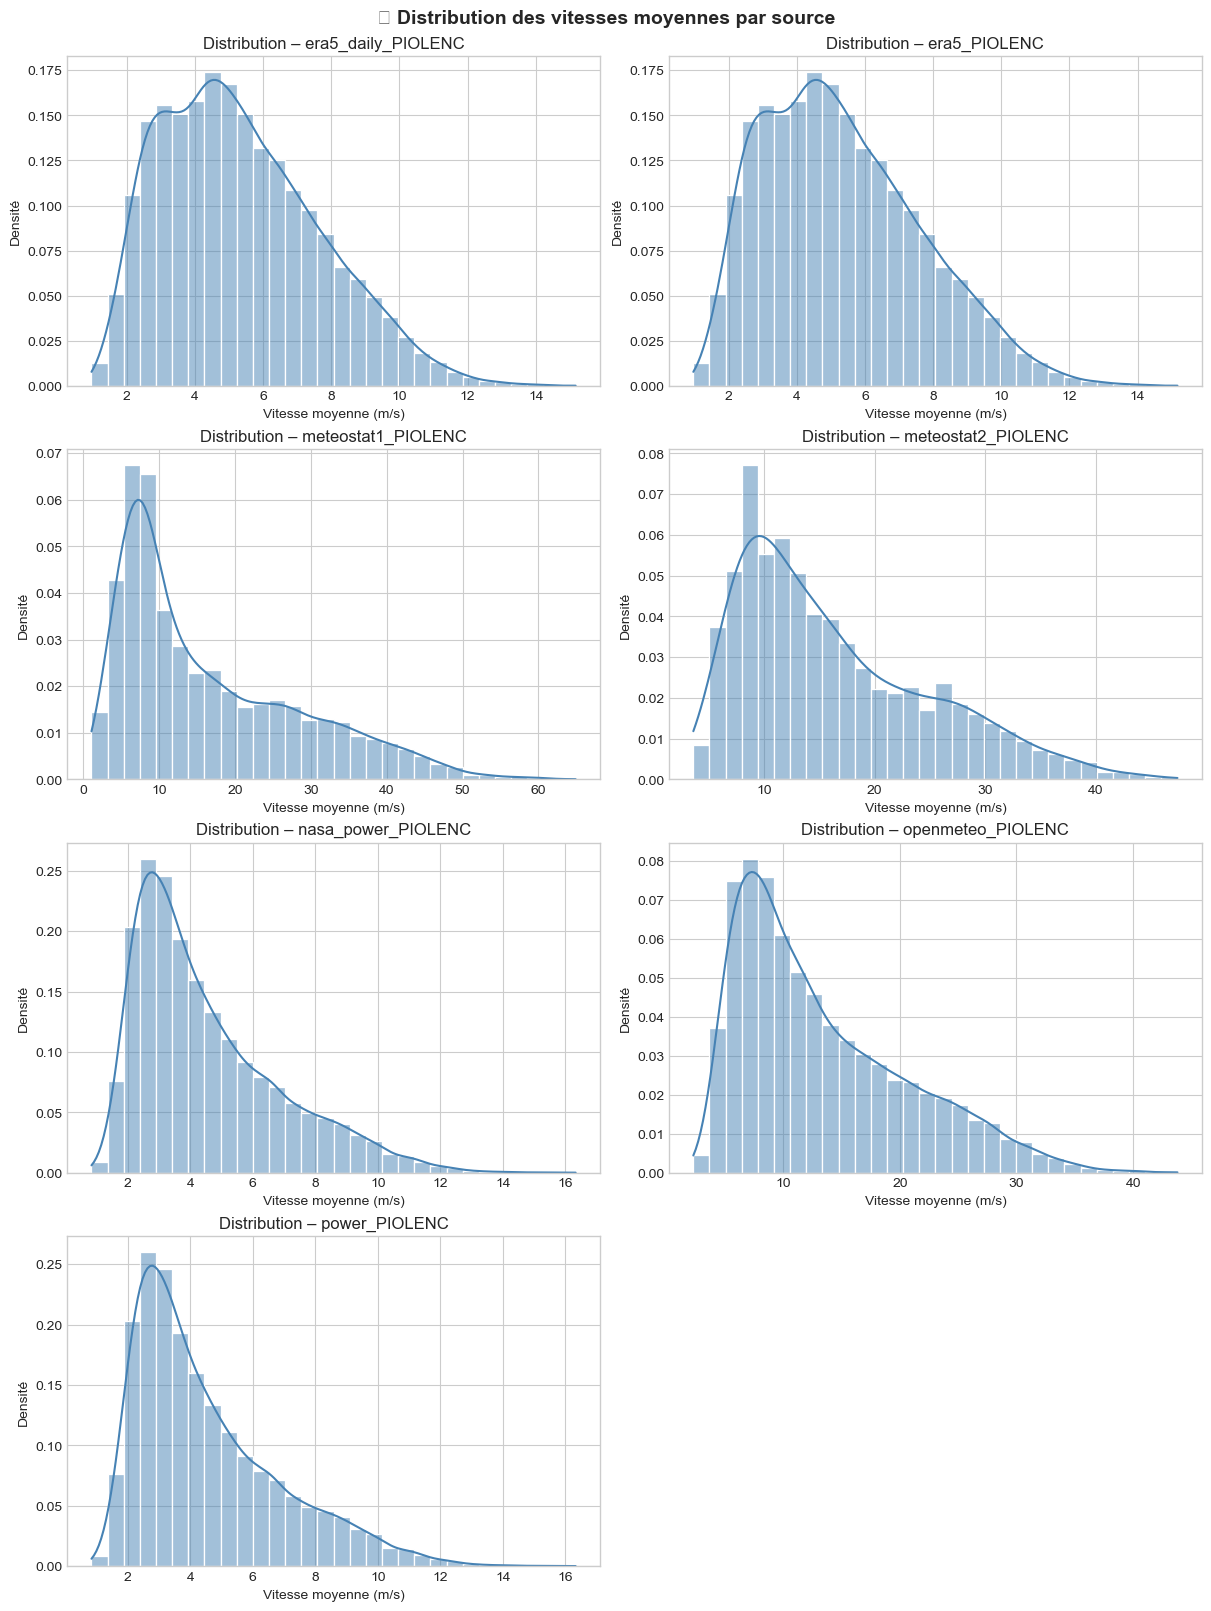

In [6]:
# ============================================================
# 📈 Histogrammes côte à côte par source (subplots)
# ============================================================

valid_sources = [(name, df["windspeed_mean"].dropna()) for name, df in dataframes.items()
                 if "windspeed_mean" in df.columns and len(df["windspeed_mean"].dropna()) >= 10]

n = len(valid_sources)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)
axes = axes.flatten() if n > 1 else [axes]

for i, (name, data) in enumerate(valid_sources):
    ax = axes[i]
    sns.histplot(data, bins=30, kde=True, stat='density', color='steelblue', ax=ax)
    ax.set_title(f"Distribution – {name}")
    ax.set_xlabel("Vitesse moyenne (m/s)")
    ax.set_ylabel("Densité")
    ax.grid(True)

# Supprimer les sous-graphiques inutiles si n est impair
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("📈 Distribution des vitesses moyennes par source", fontsize=14, fontweight='bold')
plt.show()






## 📦 Comparaison visuelle – Boxplot

Le boxplot (ou boîte à moustaches) affiche :
- médiane (trait central)
- quartiles (boîte)
- valeurs extrêmes (points hors boîte)

Il est utilisé ici pour comparer visuellement les distributions de vitesses moyennes entre sources.


,outliers
nasa_power_PIOLENC,353
power_PIOLENC,353
openmeteo_PIOLENC,174
era5_daily_PIOLENC,99
era5_PIOLENC,99
meteostat1_PIOLENC,70
meteostat2_PIOLENC,12


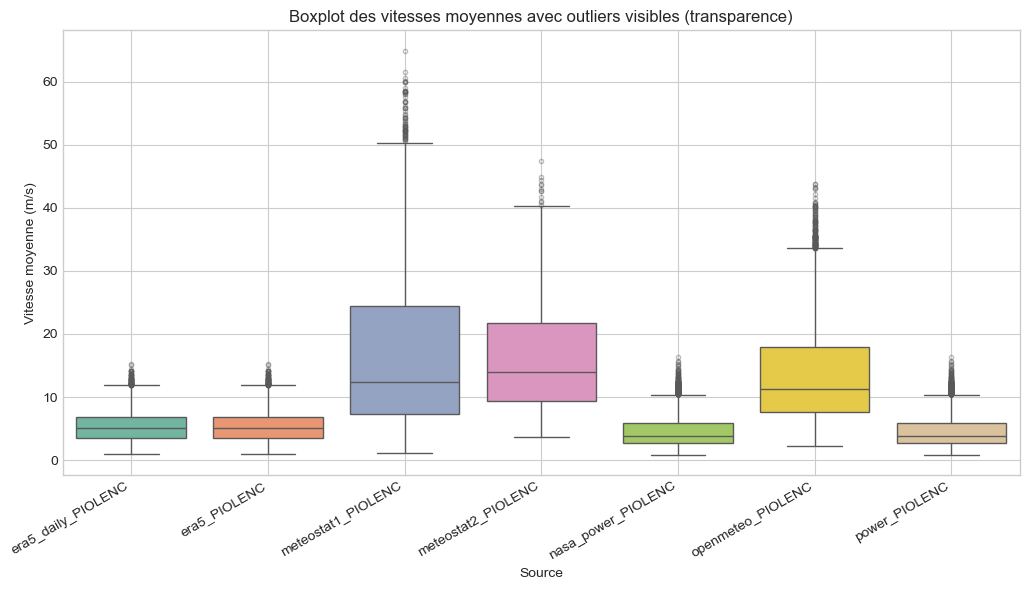

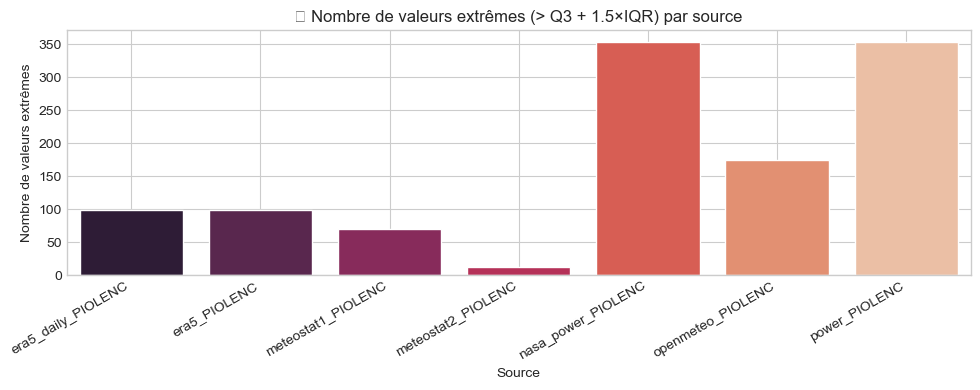

In [7]:
# ============================================================
# 📦 Boxplot avec outliers visibles + comptage des extrêmes
# ============================================================

# Fusionner les données
df_all_box = pd.concat([
    df.assign(source=name) for name, df in dataframes.items()
    if "windspeed_mean" in df.columns
], ignore_index=True)

# Détection des outliers par Tukey (Q3 + 1.5 × IQR)
outlier_counts = {}
for source in df_all_box["source"].unique():
    data = df_all_box[df_all_box["source"] == source]["windspeed_mean"].dropna()
    if len(data) < 10:
        continue
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_val = q3 - q1
    seuil_sup = q3 + 1.5 * iqr_val
    outlier_counts[source] = (data > seuil_sup).sum()

# Afficher le tableau
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["outliers"])
display(outlier_df.sort_values(by="outliers", ascending=False).style.set_caption("🔍 Nombre de valeurs extrêmes par source (> Q3 + 1.5×IQR)"))

# Afficher le boxplot avec outliers
fig, ax = plt.subplots(figsize=(max(10, len(outlier_counts) * 1.5), 6))
sns.boxplot(
    data=df_all_box,
    x="source",
    y="windspeed_mean",
    order=outlier_df.index,
    showfliers=True,
    flierprops=dict(marker='o', markersize=3, alpha=0.4),
    palette="Set2",
    ax=ax
)

ax.set_title("Boxplot des vitesses moyennes avec outliers visibles (transparence)")
ax.set_ylabel("Vitesse moyenne (m/s)")
ax.set_xlabel("Source")
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Histogramme du nombre de valeurs extrêmes
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    x=outlier_df.index,
    y=outlier_df["outliers"],
    palette="rocket",
    ax=ax
)
ax.set_title("📊 Nombre de valeurs extrêmes (> Q3 + 1.5×IQR) par source")
ax.set_ylabel("Nombre de valeurs extrêmes")
ax.set_xlabel("Source")
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()




## 🚨 Détection des valeurs extrêmes (potentiellement aberrantes)

Certaines valeurs de vent très élevées peuvent correspondre à :
- des évènements météorologiques rares
- ou des erreurs de capteur / données mal encodées

Ce bloc détecte les valeurs supérieures à un seuil configurable (`50 m/s` par défaut), et les affiche classées par ordre décroissant.


In [8]:

# ============================================================
# 🚨 Détection des vitesses moyennes ou rafales extrêmes
# ============================================================

seuil = 50  # seuil paramétrable
for name, df in dataframes.items():
    for col in ["windspeed_gust", "windspeed_mean"]:
        if col in df.columns:
            extremes = df[df[col] > seuil]
            if len(extremes) > 0:
                print(f"⚠️ {len(extremes)} valeurs > {seuil} m/s pour {name} ({col})")
                display(extremes.sort_values(by=col, ascending=False)[["time", col]].head(10))


⚠️ 725 valeurs > 50 m/s pour meteostat1_PIOLENC (windspeed_gust)


,time,windspeed_gust
7012,2019-01-05,107.4
7132,2019-05-05,101.8
7013,2019-01-06,100.0
7009,2019-01-02,98.2
7092,2019-03-26,98.2
6939,2018-10-24,98.2
7091,2019-03-25,96.3
8840,2024-01-07,96.3
7139,2019-05-12,96.3
7733,2020-12-26,94.5


⚠️ 71 valeurs > 50 m/s pour meteostat1_PIOLENC (windspeed_mean)


,time,windspeed_mean
1470,2003-04-03,64.9
3159,2008-03-05,61.5
1473,2003-04-06,60.6
5626,2015-03-05,60.1
322,1999-11-07,60.0
1996,2004-11-14,60.0
8503,2023-02-04,60.0
2808,2007-03-10,59.0
358,1999-12-20,58.5
4549,2012-02-07,58.5


⚠️ 9 valeurs > 50 m/s pour openmeteo_PIOLENC (windspeed_gust)


,time,windspeed_gust
13081,2010-10-25,54.4
13815,2012-10-28,53.3
10910,2004-11-14,50.8
17588,2023-02-26,50.8
2620,1982-03-05,50.7
16195,2019-05-05,50.6
13952,2013-03-14,50.2
1567,1979-04-17,50.1
15650,2017-11-06,50.1



## 📐 Ajustement de lois de probabilité : Weibull et Gumbel

Nous utilisons deux lois statistiques classiques pour modéliser les vitesses de vent :
- **Weibull** : souvent utilisée en ingénierie du vent (forme + échelle)
- **Gumbel** : spécialisée dans l’étude des maxima (vents extrêmes)

Ces courbes sont ajustées sur les données observées pour chaque source, puis comparées visuellement à l’histogramme empirique.


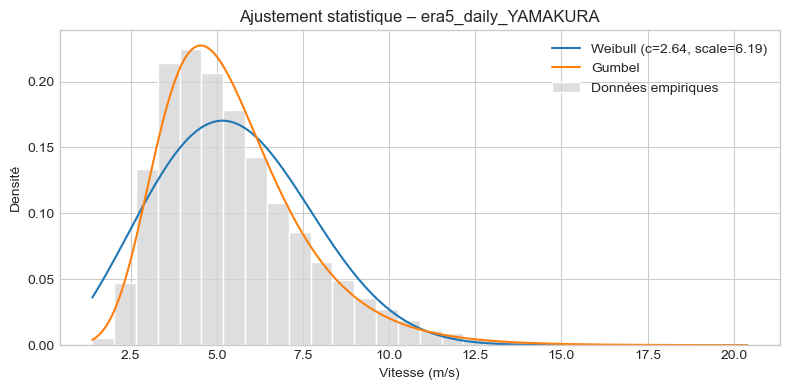

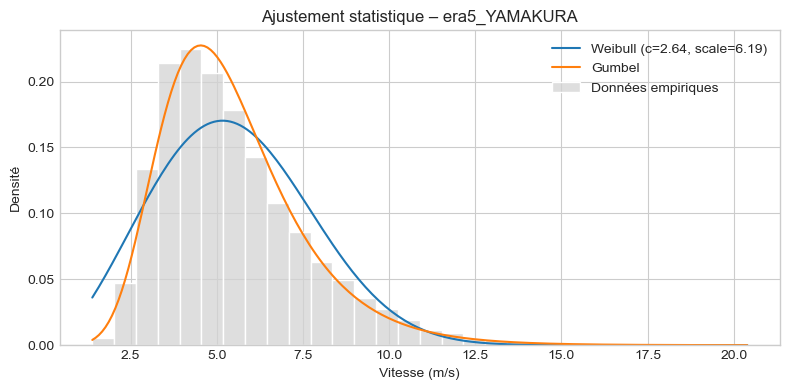

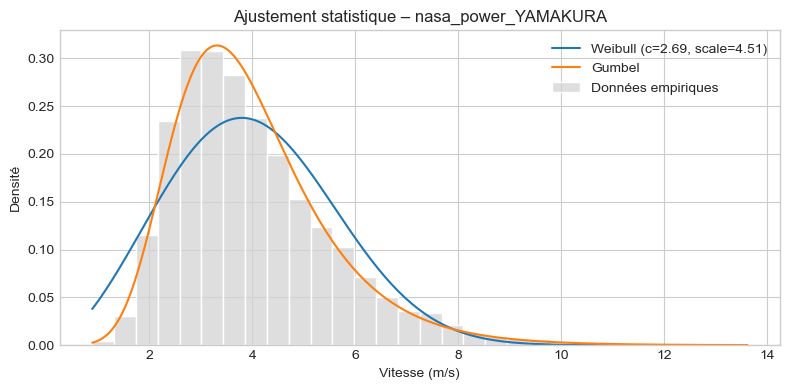

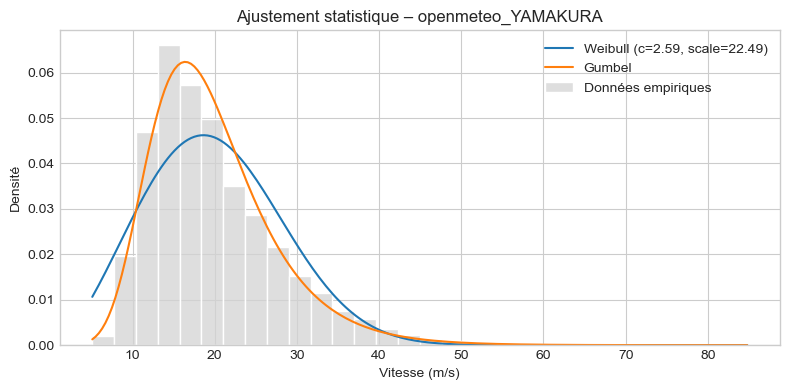

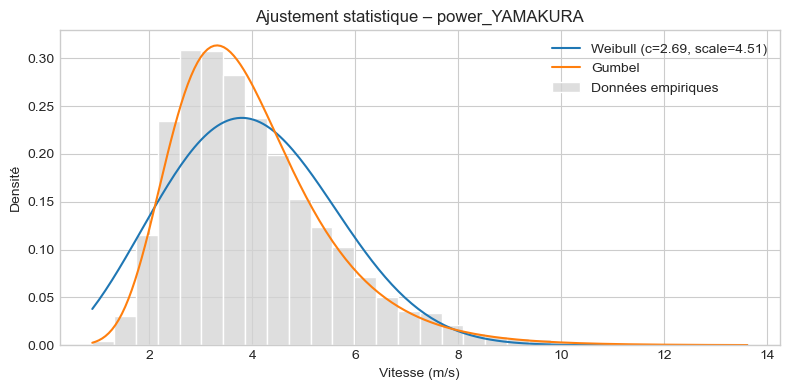

In [12]:

# ============================================================
# 📐 Ajustement de la loi de Weibull et Gumbel
# ============================================================

for name, df in dataframes.items():
    col = "windspeed_gust" if "windspeed_gust" in df.columns else "windspeed_mean"
    if col not in df.columns:
        continue

    data = df[col].dropna()
    if len(data) < 30:
        continue  # pas assez de données pour ajustement fiable

    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=30, stat='density', color='lightgray', label="Données empiriques")

    x_vals = np.linspace(data.min(), data.max(), 200)

    # Loi de Weibull (2 paramètres)
    c, loc, scale = weibull_min.fit(data, floc=0)
    weibull_pdf = weibull_min.pdf(x_vals, c, loc, scale)
    plt.plot(x_vals, weibull_pdf, label=f"Weibull (c={c:.2f}, scale={scale:.2f})")

    # Loi de Gumbel (maximum)
    loc_g, scale_g = gumbel_r.fit(data)
    gumbel_pdf = gumbel_r.pdf(x_vals, loc_g, scale_g)
    plt.plot(x_vals, gumbel_pdf, label="Gumbel")

    plt.title(f"Ajustement statistique – {name}")
    plt.xlabel("Vitesse (m/s)")
    plt.ylabel("Densité")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()



## 🔁 Comparaison croisée entre sources

Pour chaque paire de sources disponibles, nous comparons les valeurs disponibles en commun :
- Erreur absolue moyenne (MAE)
- Corrélation linéaire (Pearson)
- Nombre de jours communs

Les résultats sont affichés de manière synthétique et lisible.


In [13]:

# ============================================================
# 🔁 Comparaison croisée : MAE et Corrélation
# ============================================================

def compare_sources(df1, df2, label1, label2):
    col1 = "windspeed_gust" if "windspeed_gust" in df1.columns else "windspeed_mean"
    col2 = "windspeed_gust" if "windspeed_gust" in df2.columns else "windspeed_mean"

    if col1 not in df1.columns or col2 not in df2.columns:
        return None

    merged = pd.merge(df1[["time", col1]], df2[["time", col2]], on="time", suffixes=(f"_{label1}", f"_{label2}"))

    if merged.empty:
        return None

    mae = (merged[f"{col1}_{label1}"] - merged[f"{col2}_{label2}"]).abs().mean()
    corr = merged[f"{col1}_{label1}"].corr(merged[f"{col2}_{label2}"])
    return {
        "source_1": label1,
        "source_2": label2,
        "mae": round(mae, 2),
        "corr": round(corr, 2),
        "nb_jours": len(merged)
    }

# Calcul et affichage des comparaisons croisées
results = []
keys = list(dataframes.keys())

for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        r = compare_sources(dataframes[keys[i]], dataframes[keys[j]], keys[i], keys[j])
        if r:
            results.append(r)

results_df = pd.DataFrame(results)
if not results_df.empty:
    display(results_df.sort_values(by="mae"))
else:
    print("Aucune comparaison croisée valide.")


KeyError: 'windspeed_mean_era5_daily_YAMAKURA'